# CNN Cancer Detection — Kaggle Mini-Project

The goal of this project is to detect the presence of tumor tissue in histopathologic images of tissue node sections. Each image is a 96×96 pixel RGB patch extracted from a whole-slide scan, and a positive label indicates that **at least one pixel** in the patch contains tumor cells.

The dataset consists of 220,025 labeled training images and 57,458 unlabeled test images provided by a Kaggle competition. We aim to train a convolutional neural network (CNN) that can classify whether a given image contains any tumor tissue.

This is a binary classification task with some class imbalance (approximately 60% negative, 40% positive). We'll explore data preprocessing, augmentation, model design, and evaluation metrics.


In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

2025-04-10 11:43:55.074451: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-10 11:43:55.085946: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744253035.095306  407259 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744253035.097962  407259 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744253035.105362  407259 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Load data and display basic information

# Load data
import platform
home_directory = 'c:/datasets/' if platform.system() == 'Windows' else ''
#home_directory = 'c:/datasets/' if os.path.exists('c:/') else ''
df = pd.read_csv(home_directory + 'histopathologic-cancer-detection/train_labels.csv')

# Add image path to dataframe
df['path'] = df['id'].apply(lambda x: os.path.join(home_directory + 'histopathologic-cancer-detection/train/', f"{x}.tif"))

# Display basic info
display(df.info())
display(df.head())
print(df['label'].value_counts())

# Check for duplicate entries
duplicated_ids = df[df.duplicated(subset=['id'], keep=False)]  # Shows all duplicate occurrences
print(f"{duplicated_ids['id'].nunique()} duplicate ids")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
 2   path    220025 non-null  object
dtypes: int64(1), object(2)
memory usage: 5.0+ MB


None

,id,label,path
0,f38a6374c348f90b587e046aac6079959adf3835,0,histopathologic-cancer-detection/train/f38a637...
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,histopathologic-cancer-detection/train/c18f2d8...
2,755db6279dae599ebb4d39a9123cce439965282d,0,histopathologic-cancer-detection/train/755db62...
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,histopathologic-cancer-detection/train/bc3f0c6...
4,068aba587a4950175d04c680d38943fd488d6a9d,0,histopathologic-cancer-detection/train/068aba5...


label
0    130908
1     89117
Name: count, dtype: int64
0 duplicate ids


## EDA

For our EDA we will checked the counts of elements with tumor (1) and without tumor (0). We display 10 images from each category to examine any obvious visual differences. We also check the disribution of intensity for each of the RGB channels to see if any obvious patterns emerge.

Our analysis revealed a small class imbalance, with approximately 60% of samples labeled as 0 (no tumor) and 40% as 1 (tumor present). The class distribution is visualized below using both bar and pie charts. This imbalance is not extreme and should be manageable.

To explore visual patterns associated with each class, we randomly sampled and displayed 10 images from each class.
Images labeled as containing tumor cells often show a more violet or purplish hue, although this trend was not consistent enough across enough samples to draw statistical conclusions.

To explore the potential differences in color between the two classes, we computed the mean intensity of each RGB channel for 500 randomly sampled images from each class. We then plotted histograms comparing the distributions of red, green, and blue intensities for tumor vs. non-tumor images. Tumor images tend to have slightly higher red and blue channel intensities compared to green, which may explain the common purple tint noted in visual inspection. However, the overlap between the two classes remains substantial across all channels. This suggests that color alone is likely insufficient for high accuracy classification. However, a CNN may be able to extract spatial and more subtle color patterns that could correlate with tumor presence.

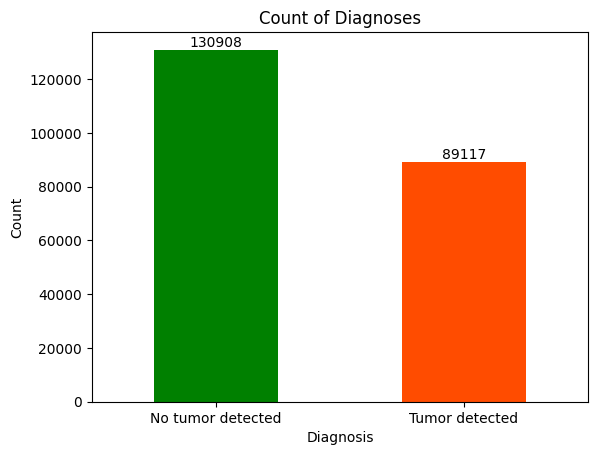

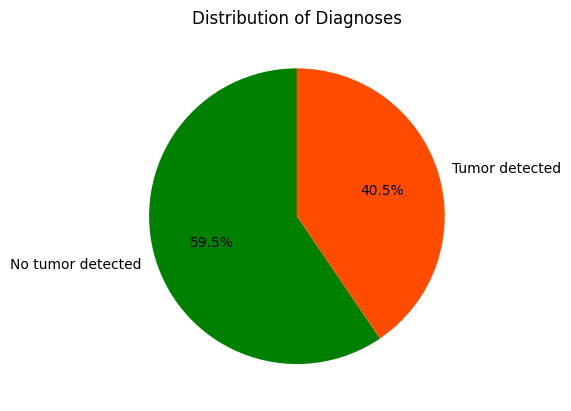

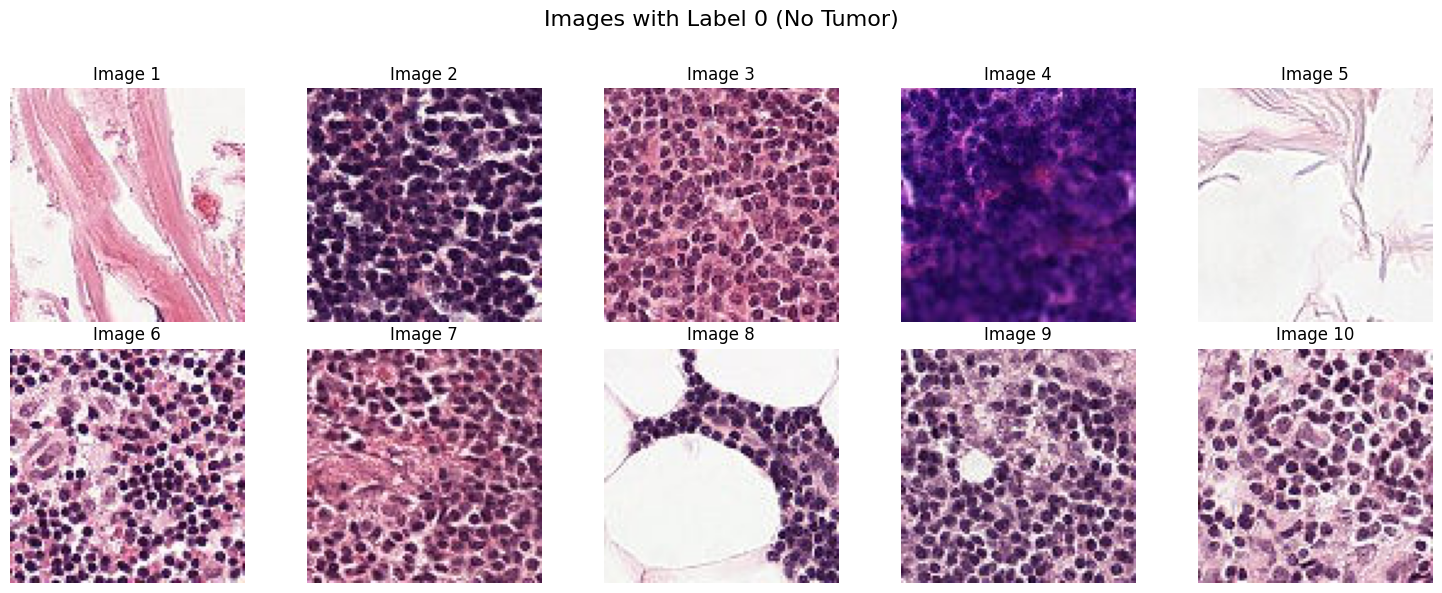

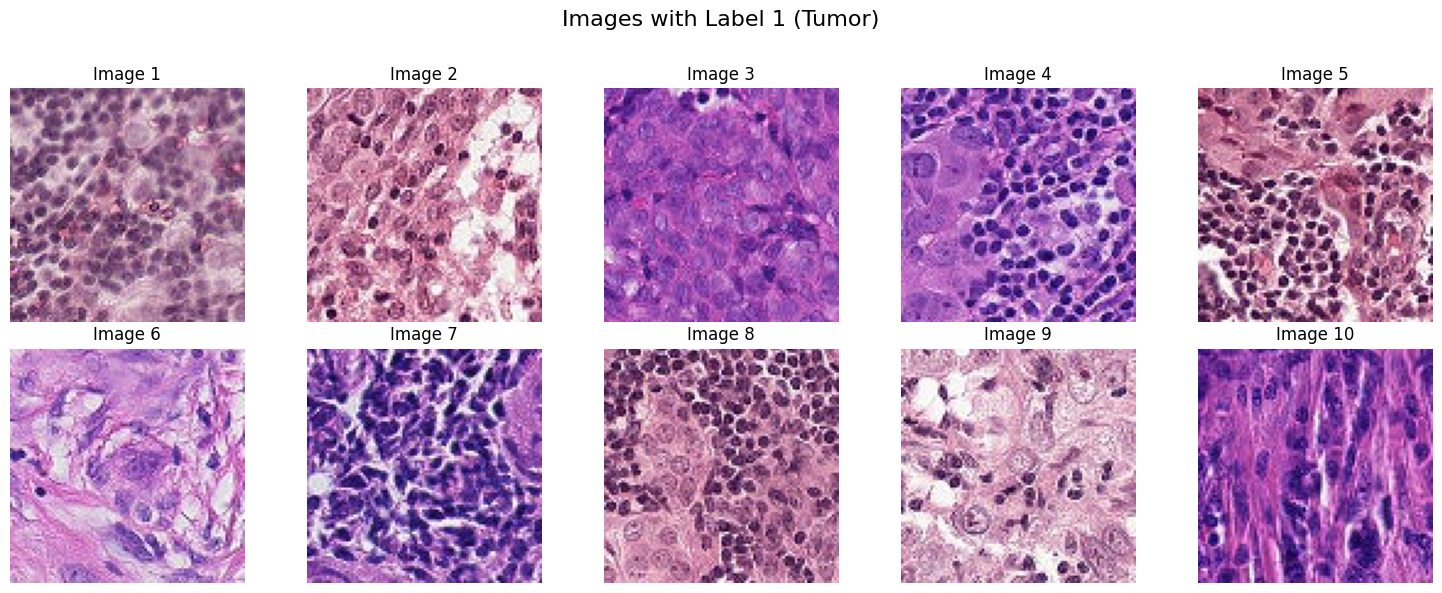

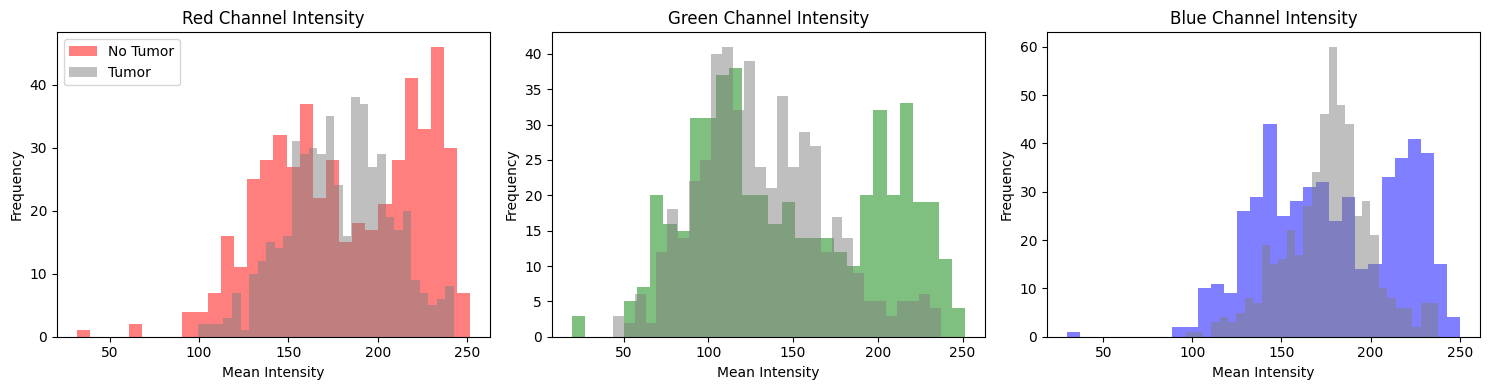

In [3]:
label_counts = df['label'].value_counts()
labels = ['No tumor detected', 'Tumor detected']

# Bar chart of label distribution
ax = label_counts.plot(kind='bar', color=['green', '#FF4C00'])

for i, count in enumerate(label_counts):
    ax.text(i, count + 0.5, str(count), ha='center', va='bottom', fontsize=10)

plt.xticks(ticks=[0, 1], labels=labels, rotation=0)  # Align text horizontally
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.title('Count of Diagnoses')
plt.show()

# Pie chart of label distribution
plt.pie(label_counts, labels=labels, autopct='%1.1f%%', colors=['green', '#FF4C00'], startangle=90)
plt.title('Distribution of Diagnoses')
plt.show()


# Show 10 randomly selected images of cancer and 10 of no cancer
def display_images(image_list, label, height=2, width=5):

    assert len(image_list) == height*width, "The number of images does not fit the dimensions provided."
    
    fig, axes = plt.subplots(height, width, figsize=(15, 6))  
    axes = axes.flatten()

    for i, (ax, img_path) in enumerate(zip(axes, image_list['path'])):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.axis('off')  # Hide axes/ticks
        ax.set_title(f"Image {i+1}")  # Optional: Label each image 

    fig.suptitle(f"Images with Label {label} ({'No Tumor' if label == 0 else 'Tumor'})", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Space for main title
    plt.show()

sample_images = [df[df['label']==i].sample(n=10, random_state=42) for i in range(2)]
for i in range(2):
    display_images(sample_images[i], i)

def compute_channel_brightness(df_subset):
    r_vals, g_vals, b_vals = [], [], []
    for path in df_subset['path']:
        img = np.array(Image.open(path))  # RGB image
        r_vals.append(img[:, :, 0].mean())
        g_vals.append(img[:, :, 1].mean())
        b_vals.append(img[:, :, 2].mean())
    return r_vals, g_vals, b_vals

# Sample 500 from each class
sample_0 = df[df['label'] == 0].sample(500, random_state=42)
sample_1 = df[df['label'] == 1].sample(500, random_state=42)

r0, g0, b0 = compute_channel_brightness(sample_0)
r1, g1, b1 = compute_channel_brightness(sample_1)

channels = ['Red', 'Green', 'Blue']
colors = ['red', 'green', 'blue']
data_0 = [r0, g0, b0]
data_1 = [r1, g1, b1]

plt.figure(figsize=(15, 4))

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.hist(data_0[i], bins=30, alpha=0.5, label='No Tumor', color=colors[i])
    plt.hist(data_1[i], bins=30, alpha=0.5, label='Tumor', color='grey')
    plt.title(f'{channels[i]} Channel Intensity')
    plt.xlabel('Mean Intensity')
    plt.ylabel('Frequency')
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()

## Preprocessing

To prepare our dataset for training, we began by splitting the original dataframe into training and validation sets using an 80/20 split. All images are uniformly sized at 96×96 pixels, so we used this as the target resolution for all model input.

To efficiently feed data into the model during training, we used Keras’ ImageDataGenerator to create data generators for both the training and validation sets. In both cases, we rescaled the RGB pixel values to the range [0, 1] by dividing by 255, a common normalization step that helps neural networks converge faster. Although we initially experimented with various data augmentation techniques (e.g., rotation, flipping, zoom), we did not observe consistent improvements in accuracy and it came at a cost of efficiency. As a result, we opted to use only rescaling in the final model pipeline to reduce training complexity and runtime. Both generators were configured with a batch size of 128, striking a balance between training speed and generalization performance.

Finally, to account for the class imbalance identified during EDA (~60% label 0, ~40% label 1), we computed class weights using scikit-learn’s compute_class_weight function. These weights were applied during training to help mitigate bias toward the majority class.

In [4]:
# Train and validation split
df_train, df_valid = train_test_split(df, test_size=0.2, random_state=42)
print(f"Train size: {df_train.shape}, Test size: {df_valid.shape}")

# Binary generators below need y label to be a string
df_train['label'] = df_train['label'].astype(str)
df_valid['label'] = df_valid['label'].astype(str)

target_size = (96, 96) # image size

# Create a generator for the training data
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    dataframe = df_train,
    directory = None,
    x_col = 'path',
    y_col = 'label',
    target_size = target_size,
    batch_size = 128,
    class_mode = 'binary'
)

# Create a generator for the validation data
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_dataframe(
    dataframe = df_valid,
    directory = None,
    x_col = 'path',
    y_col = 'label',
    target_size = target_size,
    batch_size = 128,
    class_mode = 'binary',
    shuffle = False
)

# Compute class weights
class_weights_list = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=df_train['label'].astype(int))
class_weights = {0: class_weights_list[0], 1: class_weights_list[1]}

Train size: (176020, 3), Test size: (44005, 3)
Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


## CNN Model

Compiling Model
For our binary image classification task, we used a convolutional neural network. We initially experimented with larger architectures, but found they were more prone to overfitting, with validation accuracy plateauing early. The final model strikes a balance between the capacity to learn complex features and regularization techniques to prevent overfitting.

The model consists of two convolutional blocks and takes an RGB image input of size 96×96×3. The first block contains three layers with 32 filters of size 3×3 to extract low-level features. The second block expands to 64 filters per layer to capture more abstract, higher-level features. Both blocks include max pooling layers to help the network focus on the most informative patterns. A dropout rate of 0.2 is applied after each block to reduce overfitting.

After flattening the output from the convolutional layers, we include a dense layer with 512 neurons and ReLU activation. This layer captures global patterns across the image. A higher dropout rate is applied here to prevent the network from over-relying on any particular features. The final output layer uses a sigmoid activation function to support binary classification.

The model is optimized with Adam and trained using binary cross-entropy loss. During training, we monitor both accuracy and AUC to evaluate model performance.

In [5]:
model = Sequential([
    tf.keras.Input(shape=(96, 96, 3)),

    # Convolutional Block
    SeparableConv2D(32, (3, 3), activation='relu', padding='same', use_bias=False),
    BatchNormalization(axis=-1),
    SeparableConv2D(32, (3, 3), activation='relu', padding='same', use_bias=False),
    BatchNormalization(axis=-1),
    SeparableConv2D(32, (3, 3), activation='relu', padding='same', use_bias=False),
    BatchNormalization(axis=-1),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    # Convolutional Block
    SeparableConv2D(64, (3, 3), activation='relu', padding='same', use_bias=False),
    BatchNormalization(axis=-1),
    SeparableConv2D(64, (3, 3), activation='relu', padding='same', use_bias=False),
    BatchNormalization(axis=-1),
    SeparableConv2D(64, (3, 3), activation='relu', padding='same', use_bias=False),
    BatchNormalization(axis=-1),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Flatten(),

    # Fully Connected Layer
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),

    # Output Layer
    Dense(1, activation='sigmoid')
])

#from tensorflow.keras.optimizers import Adam
#model.compile(optimizer=Adam(learning_rate=0.0008), loss='binary_crossentropy', metrics=['accuracy', 'auc'])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'auc'])
model.summary()

I0000 00:00:1744253037.326392  407259 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13689 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ separable_conv2d                │ (None, 96, 96, 32)     │           123 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 96, 96, 32)     │         1,312 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 96, 96, 32)     │         1,312 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_3              │ (None, 48, 48, 64)     │         2,336 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_4              │ (None, 48, 48, 64)     │         4,672 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_5              │ (None, 48, 48, 64)     │         4,672 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             

 Total params: 18,890,972 (72.06 MB)

 Trainable params: 18,890,396 (72.06 MB)

 Non-trainable params: 576 (2.25 KB)

### Training model

The model was trained using the data generators described in the Preprocessing section, with the number of steps per epoch set to ensure that all training images are seen once per epoch. Due to class imbalance, class weights were applied to help the model focus more on underrepresented examples. While training was set for a maximum of 50 epochs, we included early stopping to prevent overfitting and unnecessary computation.



In [6]:
checkpoint = ModelCheckpoint("best_model.keras", save_best_only=True, mode="min")
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=valid_generator,
    validation_steps=len(valid_generator),
    epochs=50,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stop]
)
model.save('model.keras')

Epoch 1/50


/home/coach/miniconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1744253039.886946  407420 service.cc:152] XLA service 0x7f0cb4007c40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744253039.886984  407420 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-04-10 11:43:59.959601: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744253040.291895  407420 cuda_dnn.cc:529] Loaded cuDNN version 90501


   1/1376 ━━━━━━━━━━━━━━━━━━━━ 4:09:58 11s/step - accuracy: 0.4531 - auc: 0.4467 - loss: 2.5300

I0000 00:00:1744253049.054606  407420 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1376/1376 ━━━━━━━━━━━━━━━━━━━━ 145s 97ms/step - accuracy: 0.7772 - auc: 0.8354 - loss: 1.8950 - val_accuracy: 0.7035 - val_auc: 0.7854 - val_loss: 0.8907
Epoch 2/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 115s 83ms/step - accuracy: 0.8468 - auc: 0.9166 - loss: 0.5602 - val_accuracy: 0.8619 - val_auc: 0.9368 - val_loss: 0.4951
Epoch 3/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 111s 81ms/step - accuracy: 0.8621 - auc: 0.9328 - loss: 0.4967 - val_accuracy: 0.8478 - val_auc: 0.9406 - val_loss: 0.4952
Epoch 4/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 111s 81ms/step - accuracy: 0.8809 - auc: 0.9475 - loss: 0.4167 - val_accuracy: 0.7231 - val_auc: 0.6453 - val_loss: 2.5832
Epoch 5/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 112s 81ms/step - accuracy: 0.8926 - auc: 0.9548 - loss: 0.3852 - val_accuracy: 0.8841 - val_auc: 0.9447 - val_loss: 0.3949
Epoch 6/50
1376/1376 ━━━━━━━━━━━━━━━━━━━━ 114s 83ms/step - accuracy: 0.8999 - auc: 0.9607 - loss: 0.3659 - val_accuracy: 0.8996 - val_auc: 0.9576 - val_loss: 0.3853
Epoch 7/50
1376/1376 

### Performance Analysis

#### Training

To evaluate the performance of the CNN model, we tracked accuracy, loss, and AUC (area under the ROC curve) across both training and validation sets during training. Accuracy provides a general sense of how many predictions the model got right, while loss reflects the model’s error in prediction and optimization. AUC is particularly useful in binary classification problems like this one, as it measures the model’s ability to distinguish between classes across all thresholds.

The training accuracy steadily improved over the epochs and reached above 94%, indicating that the model was able to learn effectively from the training data. Validation accuracy showed more fluctuation but followed a generally upward trend, ending around 93%, suggesting good generalization despite some volatility. The training loss decreased consistently, showing that the model continued to improve its fit to the data. While the validation loss was more erratic, it did not show a consistent upward trend, which suggests that overfitting was largely controlled. Finally, the AUC scores remained high for both training and validation sets throughout training, with the training AUC reaching nearly 1.0 and the validation AUC stabilizing around 0.97. These results indicate that the model maintained strong class separation and overall performance on unseen data, even with some variation across epochs.

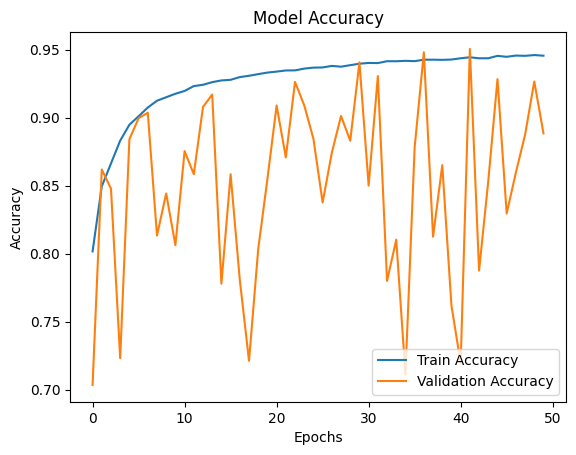

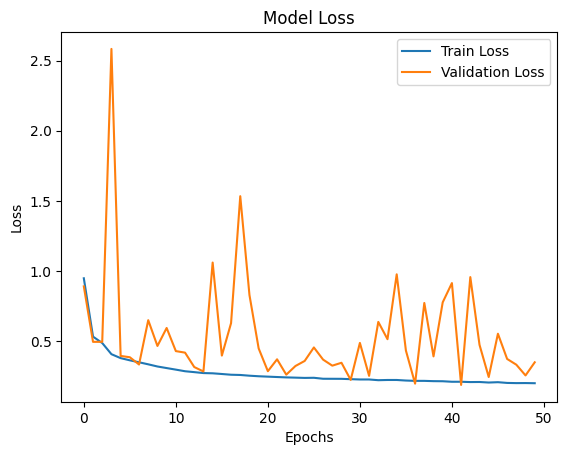

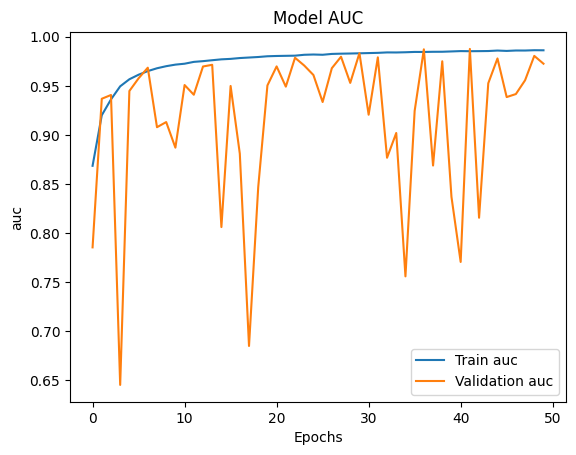

In [ ]:
# Training Plots
def plot_history(history):
    ### Training / Validation Accuracy
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.show()

    ### Training / Validation Loss
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.xlabel('Epochs')    
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.show()
    
    ### Training / Validation AUC
    plt.plot(history.history['auc'], label='Train auc')
    plt.plot(history.history['val_auc'], label='Validation auc')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('auc')
    plt.title('Model AUC')
    plt.show()

### Training / Validation Performance
plot_history(history)

#### Best epoch performance

The final model was evaluated using its best saved weights, based on validation performance. Key metrics included the confusion matrix, ROC curve, and precision-recall curve, offering a comprehensive view of its classification ability. The confusion matrix shows that the model correctly identified 24,893 negative samples and 16,485 positive samples, with only 1,037 false positives and 1,621 false negatives—indicating strong performance.

The ROC curve illustrates the model’s excellent ability to distinguish between the two classes, with an area under the curve (AUC) of 0.98. Similarly, the precision-recall curve yielded an average precision score of 0.98, confirming the model's high precision across a range of recall values. Together, these metrics suggest that the final model generalizes well and maintains strong predictive performance, making it well-suited for our binary classification of images on whether they contain tumors cells.

344/344 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step


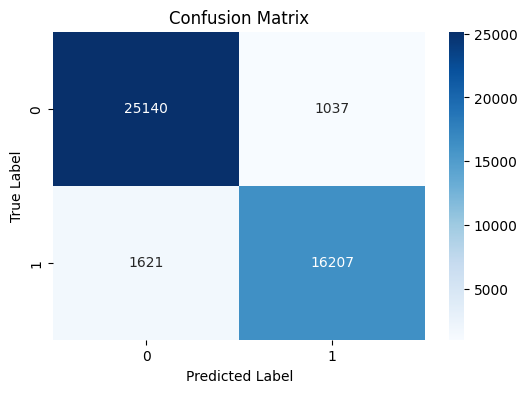

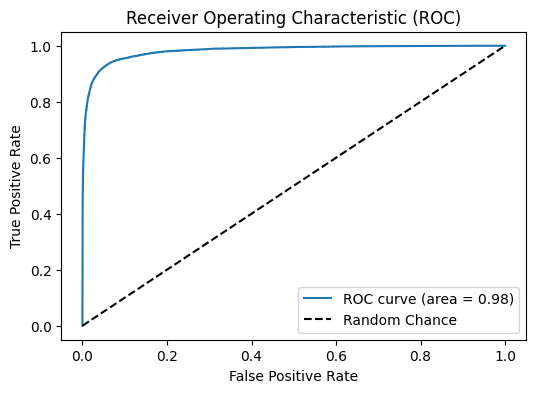

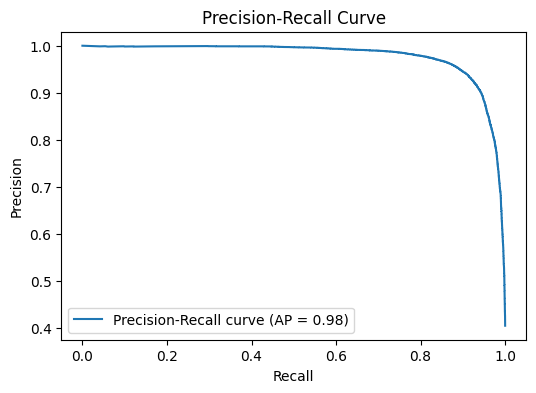

In [8]:
# Best model plots
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score

model.load_weights("best_model.h5")
model.save('model.keras')

# Function to plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names=[0, 1]):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title("Confusion Matrix")
    plt.show()

# Function to plot the ROC curve
def plot_roc_curve(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC)")
    plt.legend(loc="lower right")
    plt.show()

# Function to plot the Precision-Recall curve
def plot_precision_recall_curve(y_true, y_prob):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    avg_precision = average_precision_score(y_true, y_prob)
    plt.figure(figsize=(6,4))
    plt.plot(recall, precision, label=f"Precision-Recall curve (AP = {avg_precision:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend(loc="lower left")
    plt.show()

# A helper function to evaluate the model on a given generator
def evaluate_model(model, generator):
    # Obtain model predictions
    y_prob = model.predict(generator)
    y_prob = y_prob.ravel()
    # Convert probabilities to binary predictions using a threshold of 0.5
    y_pred = (y_prob > 0.5).astype(int)
    
    # Get ground truth labels from the generator
    y_true = generator.classes
    
    # Plot the confusion matrix
    plot_confusion_matrix(y_true, y_pred)
    
    # Plot the ROC curve
    plot_roc_curve(y_true, y_prob)
    
    # Plot the Precision-Recall curve
    plot_precision_recall_curve(y_true, y_prob)
    
# After training, evaluate the model using the validation generator
evaluate_model(model, valid_generator)

In [9]:
y_prob = model.predict(valid_generator)
y_prob = y_prob.ravel()
y_pred = (y_prob > 0.5).astype(int)
from sklearn.metrics import accuracy_score
accuracy_score(valid_generator.classes, y_pred)

344/344 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step


0.9395977729803432

## Testing Model

Using our best weights model, we predicted values for the test images from the Kaggle dataset.

In [10]:
## Testing Model

# import Test data and create dataframe
import glob
test_dir = home_directory + 'histopathologic-cancer-detection/test/'
test_df = pd.DataFrame(glob.glob(test_dir + '*.tif'), columns=['path'])

# Extract the image IDs
test_df['id'] = test_df['path'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])

target_size =(96,96)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    target_size=target_size,
    batch_size=128,
    class_mode=None,
    shuffle=False
)

# Generate predictions
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)
predicted_labels = (predictions > 0.5).astype(int)

# Add predictions to the test dataframe
test_df['label'] = predicted_labels
#display(test_df.head())

# Export predicted labels for submission to Kaggle contest
test_df[['id', 'label']].to_csv('predictions.csv', index=False)

Found 57458 validated image filenames.


/home/coach/miniconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


449/449 ━━━━━━━━━━━━━━━━━━━━ 29s 65ms/step


# Conclusion

In this project, we developed a convolutional neural network to classify histopathologic images for the presence of tumor tissue. Through careful preprocessing, class imbalance handling, and model tuning, we trained a binary classifier capable of distinguishing between tumor and non-tumor patches. We incorporated early stopping, model checkpointing, and class weighting to improve performance and avoid overfitting.

The model’s performance was evaluated using accuracy, AUC, and loss curves over time, as well as post-training metrics such as a confusion matrix, ROC curve, and precision-recall analysis. These visualizations provided some positive insights into the model's predictive behavior and its ability to balance class identifications.

While the model shows promising results, further improvements could be explored by experimenting with deeper architectures, ensembling methods, or advanced augmentation techniques. As with all neural networks, computation power is a severe limitation, so while larger networks were too computationally costly for this study, they may yeild even better predictive power. Another option for reducing computation time might be to emply a random forest or other classifier to the CNN output, rather than a dense neural layer.

Overall, this project demonstrates the potential of deep learning in medical image classification tasks and highlights the potential for deep learning methods in health diagnoses.

